# Training LSTM-250 for Phoneme Recognition on TIMIT

## Goals

- Loading feature datasets exported by previous notebook
- Model design
- Dataloader design
- Training dashboard
- Training
- Validate trained model and export it

# Environment Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
from tqdm.auto import tqdm


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.1  Device: cuda


# Loading Feature Datasets

In [2]:
train_ds_path = './session/train-features.pt'
test_ds_path = './session/test-features.pt'
train_feat_dict = torch.load(train_ds_path)
test_feat_dict  = torch.load(test_ds_path)

In [3]:
print(train_feat_dict.keys())
print(train_feat_dict['note'])
print(train_feat_dict['data-schema'])

Train_feat = train_feat_dict['data']
print('Train_feat:', len(Train_feat))
print('Feature-len:', len(Train_feat[0][1]))

dict_keys(['note', 'data-schema', 'data'])

Notes:
- Feature record: (phone, feature_sequence)
- feature_seqence: list(feature_vector)
- len(feature_vector): 123

Features are extracted using following parameters
F_n_mfcc    : 40
F_fft_window: 256
F_hop_length: 64
F_n_mels    : 128

(phoneme, feature-sequence)
Train_feat: 51848
Feature-len: 123


In [4]:
print(test_feat_dict.keys())
print(test_feat_dict['note'])
print('data-schema:', test_feat_dict['data-schema'])

Test_feat = test_feat_dict['data']
Feature_length = len(Test_feat[0][1])
print('Train_feat:', len(Test_feat))
print('Feature-len:', Feature_length)

dict_keys(['note', 'data-schema', 'data'])

Notes:
- Feature record: (phone, feature_sequence)
- feature_seqence: list(feature_vector)
- len(feature_vector): 123

Features are extracted using following parameters
F_n_mfcc    : 40
F_fft_window: 256
F_hop_length: 64
F_n_mels    : 128

data-schema: (phoneme, feature-sequence)
Train_feat: 7333
Feature-len: 123


In [5]:
# Delete redundant names to avoid confusions
del train_ds_path, test_ds_path, train_feat_dict, test_feat_dict

## Show Some Data points

**NOTE:**
- Observe that the feature sequence layout is (feature-vector, sequence-point)
- For LSTM training, it needs to be transposed to make it (sequence-point, feature-vector)

In [6]:
# Given an item from Train/Test_feat, shows some information
# feat_item: (phone, feature-sequence)
def showFeatInfo(feat_item, end=''):    
    print('item type:', type(feat_item))
    phone, feat_seq = feat_item
    print('phone:', phone)
    print('feat-seq type:', type(feat_seq), feat_seq.dtype)
    print('feat_seq:', feat_seq.shape, end)


# show a few items
showFeatInfo(Train_feat[0], end='\n')
showFeatInfo(Train_feat[3], end='\n')

showFeatInfo(Test_feat[0], end='\n')
showFeatInfo(Test_feat[3], end='\n')

item type: <class 'list'>
phone: h#
feat-seq type: <class 'numpy.ndarray'> float32
feat_seq: (123, 42) 

item type: <class 'list'>
phone: l
feat-seq type: <class 'numpy.ndarray'> float64
feat_seq: (123, 17) 

item type: <class 'list'>
phone: h#
feat-seq type: <class 'numpy.ndarray'> float32
feat_seq: (123, 38) 

item type: <class 'list'>
phone: s
feat-seq type: <class 'numpy.ndarray'> float32
feat_seq: (123, 17) 



## Convert to float32

Convert feature datatypes to float32. Some features are set as float64 in the previous notebook.

In [7]:
# Given a feature dataset, returns all dtypes of the feature-sequences
def getAllDtype(feat_ds):
    all_type = set()
    for item in feat_ds:
        _, feat_seq = item
        all_type.add(feat_seq.dtype)
    return all_type


train_dtypes = getAllDtype(Train_feat)
test_dtypes  = getAllDtype(Test_feat)
print('train_dtypes:', train_dtypes)
print('test_dtypes :', test_dtypes)

train_dtypes: {dtype('float32'), dtype('float64')}
test_dtypes : {dtype('float32'), dtype('float64')}


In [8]:
# Given a feature dataset, converts all feature-sequence into target datatype
def changeDtype(feat_ds, target_dtype):
    for item in feat_ds:
        item[1] = item[1].astype(target_dtype)
        
        
# Convert datatypes
changeDtype(Train_feat, np.float32)
changeDtype(Test_feat, np.float32)

# Show after conversion
train_dtypes = getAllDtype(Train_feat)
test_dtypes  = getAllDtype(Test_feat)
print('train_dtypes:', train_dtypes)
print('test_dtypes :', test_dtypes)

train_dtypes: {dtype('float32')}
test_dtypes : {dtype('float32')}


In [9]:
# Delete names to avoid confusion
del train_dtypes, test_dtypes

## Transpose Feature Sequences

In [10]:
# Given a feature dataset, transposes the feature sequences
def transposeFeatSeq(feat_ds):
    for item in feat_ds:
        item[1] = item[1].T
        
        
# Transpose the feature datasets
transposeFeatSeq(Train_feat)
transposeFeatSeq(Test_feat)

# show a few item info
showFeatInfo(Train_feat[0], end='\n')
showFeatInfo(Train_feat[3], end='\n')

showFeatInfo(Test_feat[0], end='\n')
showFeatInfo(Test_feat[3], end='\n')

item type: <class 'list'>
phone: h#
feat-seq type: <class 'numpy.ndarray'> float32
feat_seq: (42, 123) 

item type: <class 'list'>
phone: l
feat-seq type: <class 'numpy.ndarray'> float32
feat_seq: (17, 123) 

item type: <class 'list'>
phone: h#
feat-seq type: <class 'numpy.ndarray'> float32
feat_seq: (38, 123) 

item type: <class 'list'>
phone: s
feat-seq type: <class 'numpy.ndarray'> float32
feat_seq: (17, 123) 



## Build the Labels Dictionary

In [11]:
# Given a feature dataset, returns the set of all labels
def getAllLabels(feat_ds):
    labels = set()
    for item in feat_ds:     # item: (label, feature-sequence)
        labels.add(item[0])
    return labels


# Build the labels dictionary
all_train_labels = getAllLabels(Train_feat)
all_test_labels  = getAllLabels(Test_feat)

print('all_train_labels:', len(all_train_labels), '\n', all_train_labels)
print('all_test_labels :', len(all_test_labels) , '\n', all_test_labels)

print('')
Label_to_index = {label:index for index, label in enumerate(all_train_labels)}
Index_to_label = {index:label for label, index in Label_to_index.items()}
print('Label_to_index:\n', Label_to_index)
print('Index_to_label:\n', Index_to_label)

all_train_labels: 39 
 {'eh', 'r', 'iy', 'ng', 'hh', 'ow', 'ih', 'f', 'y', 'h#', 'g', 'jh', 'ae', 'w', 'sh', 'ay', 'n', 'dh', 'aa', 'z', 'v', 'ch', 'uh', 'ah', 'k', 'aw', 'd', 'l', 'b', 'er', 'dx', 's', 'm', 'p', 'ey', 'uw', 't', 'oy', 'th'}
all_test_labels : 39 
 {'eh', 'r', 'iy', 'ng', 'hh', 'ow', 'ih', 'f', 'y', 'h#', 'g', 'jh', 'ae', 'w', 'sh', 'ay', 'dh', 'n', 'v', 'z', 'aa', 'ch', 'uh', 'ah', 'k', 'aw', 'd', 'l', 'b', 'er', 'dx', 's', 'm', 'p', 'ey', 'uw', 't', 'oy', 'th'}

Label_to_index:
 {'eh': 0, 'r': 1, 'iy': 2, 'ng': 3, 'hh': 4, 'ow': 5, 'ih': 6, 'f': 7, 'y': 8, 'h#': 9, 'g': 10, 'jh': 11, 'ae': 12, 'w': 13, 'sh': 14, 'ay': 15, 'n': 16, 'dh': 17, 'aa': 18, 'z': 19, 'v': 20, 'ch': 21, 'uh': 22, 'ah': 23, 'k': 24, 'aw': 25, 'd': 26, 'l': 27, 'b': 28, 'er': 29, 'dx': 30, 's': 31, 'm': 32, 'p': 33, 'ey': 34, 'uw': 35, 't': 36, 'oy': 37, 'th': 38}
Index_to_label:
 {0: 'eh', 1: 'r', 2: 'iy', 3: 'ng', 4: 'hh', 5: 'ow', 6: 'ih', 7: 'f', 8: 'y', 9: 'h#', 10: 'g', 11: 'jh', 12: 'ae',

In [12]:
# Delete names to avoid confusions in later sections
del all_train_labels, all_test_labels

# Model Design

In [13]:
import torch.nn.utils.rnn as rnn_utils


# LSTM model definition
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.debug = False    # Set it to true to print debug info
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    # Expects a padded_sequence of batched input and the lengths of the sequences
    def forward(self, pad_seq, lengths):        
        if self.debug: print('DEBUG START: LSTM model ---')

        # Extract batch size for initialization of hidden state
        batch_size = len(pad_seq)
            
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        
        # Convert padded sequence to variable length packed sequence for LSTM
        packed_seq = rnn_utils.pack_padded_sequence(pad_seq, lengths, enforce_sorted=False, batch_first=True)
        
        # Forward propagate LSTM, returns a packed sequence
        out_packed, _ = self.lstm(packed_seq, (h0, c0))
        
        # Extract final hidden states of each sequence for the output layer
        out_pad, out_lens = rnn_utils.pad_packed_sequence(out_packed, batch_first=True)
        out_indx = out_lens - 1   # indices of the last valid hidden state in the padded sequence
        last_hidden = out_pad[range(batch_size), out_indx].contiguous()  # select the last valid state in each sequence, and make them contiguous for efficiency
                
        if self.debug:
            print('last_hidden size:', last_hidden.size())
            print('last_hidden:\n', last_hidden)
        
        # Decode the hidden state of the last time step only (for whole batch)
        out = self.fc(last_hidden)
        if self.debug: print('DEBUG END: LSTM model ---')
        return out

In [14]:
# Instantiate the LSTM
input_size  = Feature_length    # no. of mfcc coefficients
hidden_size = 250               # no. of hiddent units in LSTM
num_layers  = 3
num_classes = len(Label_to_index)
model_lstm250  = LSTM(input_size, hidden_size, num_layers, num_classes)
model_lstm250.to(device)
print(model_lstm250)


# Save the model parameters
Hparam = {
    'input_size' : input_size,
    'hidden_size': hidden_size,
    'num_layers' : num_layers,
    'num_classes': num_classes, 
}


# Delete temporary names
del input_size, hidden_size, num_layers, num_classes

LSTM(
  (lstm): LSTM(123, 250, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=250, out_features=39, bias=True)
)


# Dataloader Design

## Dataset Class

In [15]:
# Use librosa.display.specshow to display 2D features
def plotSpecshow(data, fig, axis):
    img = librosa.display.specshow(data, ax=axis)
    fig.colorbar(img, ax=axis)
    return img


# Given a feature-sequence, breaks down different parts then plots it
def showFeatures(feature_sequence):    # feature_sequence: (sequence-point, feature-vector)
    feat_seq = feature_sequence.T      # Transpose it to make it the way plotSpecshow() expects
    
    fig = plt.figure(figsize=(12, 5))
    fig.subplots_adjust(hspace=0.5)
    fig.tight_layout()

    mfcc = feat_seq[0:40, :]     # extract the mfcc coefficients only
    ax_mfcc = fig.add_subplot(2, 2, 1)
    ax_mfcc.set_title('MFCC')
    plotSpecshow(mfcc, fig, ax_mfcc)

    energy = feat_seq[40, :]     # extract energy only
    ax_energy = fig.add_subplot(2, 2, 2)
    ax_energy.set_title('Energy')
    ax_energy.semilogy(energy)
    
    delta1 = feat_seq[41:82, :]  # extract delta1 only
    ax_delta1 = fig.add_subplot(2, 2, 3)
    ax_delta1.set_title('Delta-1')
    plotSpecshow(delta1, fig, ax_delta1)

    delta2 = feat_seq[82:, :]    # extract delta2 only
    ax_delta2 = fig.add_subplot(2, 2, 4)
    ax_delta2.set_title('Delta-2')
    plotSpecshow(delta2, fig, ax_delta2)

In [16]:
from torch.utils.data import Dataset


class TimitPhoneDataset(Dataset):
    def __init__(self, feature_ds):
        self.base_dataset = feature_ds    # list of (phoneme, feature-sequence)
           
    def __len__(self):
        return len(self.base_dataset)
 
    # Returns: (phoneme, feature-sequence)
    def __getitem__(self, index):
        return self.base_dataset[index]
         
    
# Instantiate the Dataset objects
Train_dataset = TimitPhoneDataset(Train_feat)
Test_dataset  = TimitPhoneDataset(Test_feat)

phone: f
feat_seq: (25, 123)


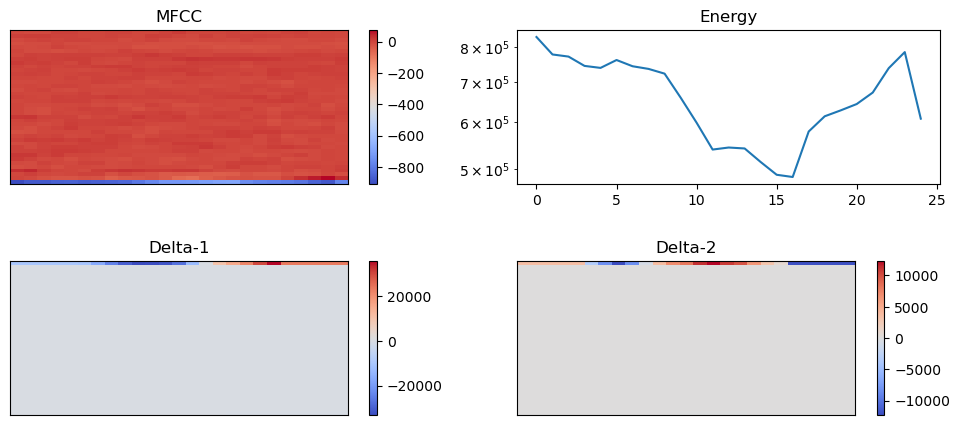

In [17]:
# Test if it works as expected
phone, feat_seq = Test_dataset[23]
print('phone:', phone)
print('feat_seq:', feat_seq.shape)
showFeatures(feat_seq)

phone: h#
feat_seq: (22, 123)


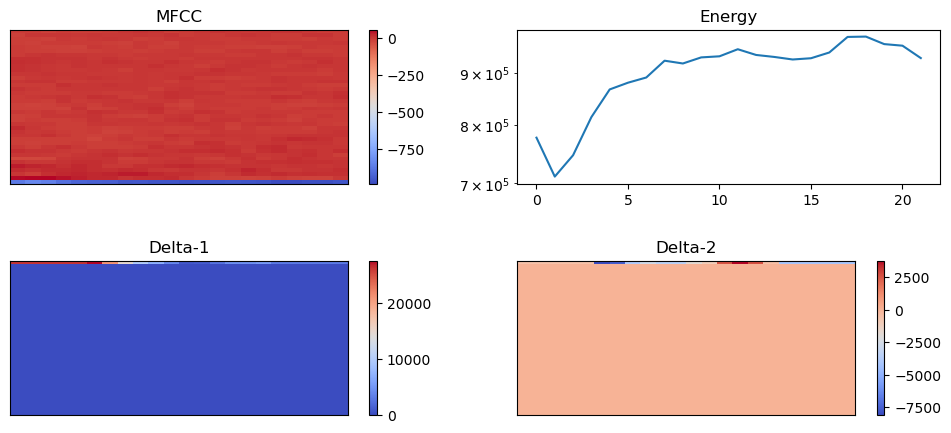

In [18]:
phone, feat_seq = Train_dataset[1050]
print('phone:', phone)
print('feat_seq:', feat_seq.shape)
showFeatures(feat_seq)

In [19]:
# Delete temporary names
del phone, feat_seq

## Dataloaders

In [20]:
# Padding is needed to make the batch <tensor> from <list> of variable length sequences
# The padding values are not passed to the LSTM during trainig/testing
def pad_sequence_lstm(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = rnn_utils.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch

# Gets the list of audio and labels as batch then
# converts them into sequence of features for the model.
# Adds padding to build the batch tensor
def collate_fn_lstm(batch):
    # A data tuple has the form: (phoneme, wave, sample_rate)
    tensors, targets, lengths = [], [], []   # lengths is needed for pack_padded_sequence  in LSTM.forward()

    # Gather in lists, and encode labels as indices
    for item in batch:
        label, feat_seq = item
        feat_seq_tensor = torch.from_numpy(feat_seq)
        tensors += [feat_seq_tensor]
        targets += [Label_to_index[label]]
        lengths.append(feat_seq_tensor.size()[0])

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence_lstm(tensors)
    targets = torch.tensor(targets)
    lengths = torch.tensor(lengths)
    return tensors, targets, lengths

In [21]:
# Test padding function
batch = [   torch.tensor([2,3,4,5]), 
            torch.tensor([2,3]),
            torch.tensor([5,6,7])    ]
pad_seq = pad_sequence_lstm(batch)
print('pad_seq:\n', pad_seq)


# Test collate function
batch = [Train_dataset[i*21] for i in range(5)]
col_tensor, col_targets, col_lengths = collate_fn_lstm(batch)
print('\ncollate_out:\n', col_tensor.size(), '\n', col_targets, '\n', col_lengths)


# Manual features to compare
print('')
phone, feat_seq = batch[2]
print('phone:', phone)
print('feat_seq shape:', feat_seq.shape)


# Delete names to avoid confusion later
del batch, pad_seq
del col_tensor, col_targets, col_lengths
del phone, feat_seq

pad_seq:
 tensor([[2, 3, 4, 5],
        [2, 3, 0, 0],
        [5, 6, 7, 0]])

collate_out:
 torch.Size([5, 38, 123]) 
 tensor([ 9,  6,  9, 13,  2]) 
 tensor([38, 17, 17, 17, 23])

phone: h#
feat_seq shape: (17, 123)


In [22]:
# Instantiate the Dataloaders

Batch_size_train = 64
Batch_size_test = 256


if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

    
Train_loader = torch.utils.data.DataLoader(
    Train_dataset,
    batch_size=Batch_size_train,
    shuffle=True,
    collate_fn=collate_fn_lstm,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Test_loader = torch.utils.data.DataLoader(
    Test_dataset,
    batch_size=Batch_size_test,
    shuffle=False,
    #shuffle=True,        # make it True for fractional validation
    drop_last=False,
    collate_fn=collate_fn_lstm,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [23]:
# Test the dataloaders
for (sequence, labels, lengths) in Train_loader:
    print('sequence:', sequence.size(), 'type:', sequence.type())
    print('labels  :', labels.size(), 'type:', labels.type())
    print('lengths :', lengths.size(), 'type:', lengths.type())
    break
    
print('')
for (sequence, labels, lengths) in Test_loader:
    print('sequence:', sequence.size(), 'type:', sequence.type())
    print('labels  :', labels.size(), 'type:', labels.type())
    print('lengths :', lengths.size(), 'type:', lengths.type())
    break
    
    
# Delete names
del num_workers, pin_memory, sequence, labels, lengths

sequence: torch.Size([64, 51, 123]) type: torch.FloatTensor
labels  : torch.Size([64]) type: torch.LongTensor
lengths : torch.Size([64]) type: torch.LongTensor

sequence: torch.Size([256, 76, 123]) type: torch.FloatTensor
labels  : torch.Size([256]) type: torch.LongTensor
lengths : torch.Size([256]) type: torch.LongTensor


# Setting up Training Elements

## Training Method

In [24]:
from math import ceil


# The training method should not access global names to avoid confusions.
# The only global name allowed is the Train_loader.
# options and dashboard arguments are used to pass other global elements. 
def train_model(model, options, dashboard, debug=False):
    # Get options and dashboard elements
    criterion  = options['criterion']
    optimizer  = options['optimizer']
    log_interval = options['log_interval']
    epoch_pbar   = dashboard['epoch_pbar']
    
    # Training initial setup
    model.train()
    model.debug = debug
    epoch_pbar.reset()
    
    # Run the training loop
    for batch_idx, (sequence, target, lengths) in enumerate(Train_loader):
        sequence = sequence.to(device)
        target = target.to(device)

        # Run through model and compute loss
        output = model(sequence, lengths)
        loss = criterion(output, target)    # compute batch loss

        # Update gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update dashboard and print at log intervals
        epoch_pbar.update(1)   # update the epoch progress bar
        is_log_step = (batch_idx % log_interval == 0)
        if is_log_step: updateTrainingStat( options, dashboard, batch_idx, 
                                            len(sequence), len(Train_loader), loss )    
        # DEBUG
        if debug and batch_idx == 100: 
            print('DBG: Breaking prematurely')
            break
    model.debug = False
    
    
# Update training status
def updateTrainingStat(options, dashboard, batch_idx, sequence_len, Train_len, loss):
    # Get options and dashboard elements
    print_stat = options['print_stat']       # a true/false value
    cur_epoch  = options['cur_epoch']        # current epoch number
    train_loss = options['train_loss']       # a list to keep track of training loss, passed from top-level
    plot_fig_ax = dashboard['plot_fig_ax']  # figure and axis handles for plotting
    
    # printing status (for short training sessions)
    if print_stat:
        printTrainingStat(cur_epoch, batch_idx, sequence_len, Train_len, loss)

    # record and plot loss
    train_loss.append(loss.item())
    if plot_fig_ax:
        fig, ax = plot_fig_ax
        ax.plot(train_loss, color='b')
        fig.canvas.draw()

        
# Prints the training stats
def printTrainingStat(cur_epoch, batch_idx, sequence_len, Train_len, loss):
    print('Train Epoch: {} [{:6}/{} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                      cur_epoch, batch_idx * sequence_len, Train_len,
                      100. * batch_idx / Train_len, loss.data.item()) )

## Testing Method

In [25]:
def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


# Returns percent accuracy
# User fraction: <1.0 to run validation on a fraction of the test data
def test_model(model, options, debug=False):
    # Get options
    criterion = options['criterion']
    fraction  = options['test_fraction']   # <= 1.0
    print_stat = options['print_stat']     # true/false value
    
    # Testing initial setup
    model.eval()
    model.debug = debug
    # Compute the stop batch no. based on fraction
    total_batch = ceil(len(Test_dataset)/Batch_size_test)
    stop_count = int(ceil(total_batch*fraction))
    
    # Run the test dataset through the model
    loss, correct = 0, 0
    tested_count = 0
    for sequence, targets, lengths in Test_loader:
        sequence = sequence.to(device)
        targets = targets.to(device)
        outputs = model(sequence, lengths)
        loss += criterion(outputs, targets).data.item()
        pred = get_likely_index(outputs) # get the index of the max log-probability
        correct += number_of_correct(pred, targets)
        tested_count += len(targets)  # increment the tested item counter
        # Run only on the given fraction
        stop_count -= 1
        if stop_count < 0: break
    model.debug = False
    
    # Print statistics
    loss /= tested_count
    test_loss.append(loss)
    accuracy = (100.0 * correct) / tested_count
    test_accuracy.append(accuracy)
    
    if print_stat:
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
                 loss, correct, tested_count, accuracy))
    return accuracy

## Training Dashboard

In [26]:
%matplotlib notebook
from ipywidgets.widgets import HTML
import IPython.display as ipd
from copy import deepcopy


# Make a widget to show status text at the top of the cell
status_text = HTML()
status_init = "<b>Status:</b> Start the training"
status_start = "<b>Status:</b> Training started ..."
status_end   = "<br><b style='color:green'>Training Done!</b>"


# Given the parameters, updates the status_text widget
def updateStatusText(target_models, cur_accuracy, best_accuracy, learn_rate):
    param_style = 'style="color:indianred"'
    text = f'<b>Status:</b> target-model #: <b {param_style}>{{}}</b> cur-acc: <b {param_style}>{{:.2f}}%</b>   best-acc: <b {param_style}>{{:.2f}}%</b> lr: <b {param_style}>{{}}</b>'
    status_text.value = text.format(len(target_models), cur_accuracy, best_accuracy, learn_rate)


# Call this function where you want to show the interactive plot
fig_train = None
ax_trainloss = None
ax_testloss = None
ax_testaccu = None
  
def showTrainPlot_2row():
    global fig_train, ax_trainloss, ax_testloss, ax_testaccu
    fig_height = 4.5
    fig_train = plt.figure("Training Progress", figsize=(2*fig_height, fig_height))
    # Training loss axis
    ax_trainloss = fig_train.add_subplot(2, 1, 1)
    ax_trainloss.set_title("Training Loss")
    # Test (validation) loss axis
    ax_testloss = fig_train.add_subplot(2, 2, 3)
    ax_testloss.set_title("Test Loss")
    # Test (validation) accuracy axis
    ax_testaccu = fig_train.add_subplot(2, 2, 4)
    ax_testaccu.set_title("Test Accuracy")
    plt.subplots_adjust(hspace=0.2)
    fig_train.tight_layout()

    
# Call this function to update the plot
def updateTrainPlot(test_loss, test_accuracy):
    ax_testloss.plot(test_loss, color='g')
    ax_testaccu.plot(test_accuracy, color='g')
    fig_train.canvas.draw()


# Define the container to save the best models
Saved_models = {-1:'Dummy'}

# Run Training

In [31]:
from torch import optim

# Define optimizer and loss function
criterion   = nn.CrossEntropyLoss()
optimizer   = optim.Adam(model_lstm250.parameters(), lr=0.001, weight_decay=0.0001)
lrScheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)  # reduce the learning after given steps by a factor of 10

Full Training:   0%|          | 0/30 [00:00<?, ?it/s]

This Epoch  :   0%|          | 0/115 [00:00<?, ?it/s]

HTML(value='<b>Status:</b> Start the training')

<IPython.core.display.Javascript object>


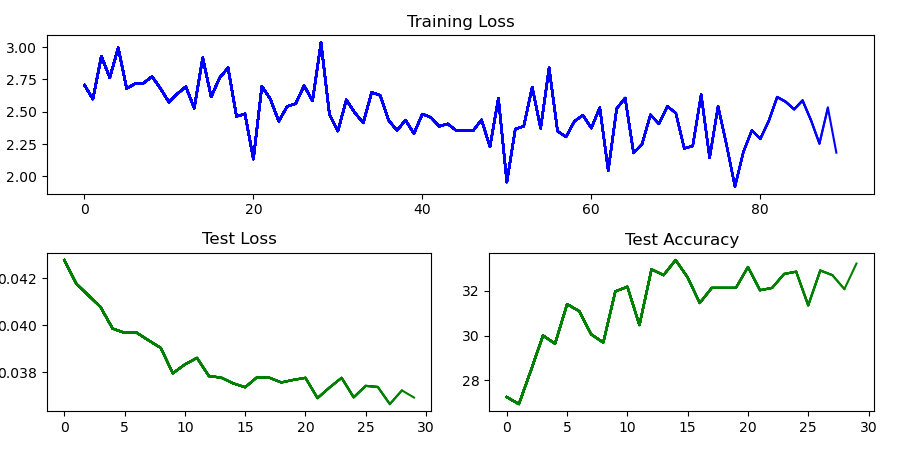

In [32]:
# Training loop parameters
n_epoch = 10
target_accuracy = 70.0  # percent
train_print_stat = False
test_print_stat = False
test_fraction = 1.0   # run validation on random fraction of the test dataset
log_interval_percent = 20
log_interval = (len(Train_dataset)//Batch_size_train) * log_interval_percent // 100


# Tracking variables
train_loss = []
test_loss = []
test_accuracy = []
target_models = {}
best_accuracy = -1
best_model = None


# Set up training dashboard
epoch_iter = tqdm(range(n_epoch), desc="Full Training")
total_train_batch = ceil(len(Train_dataset)/Batch_size_train)
epoch_pbar = tqdm(total=total_train_batch, desc='This Epoch  ')
status_text.value = status_init
ipd.display(status_text)
#ipd.display(substatus_text)
showTrainPlot_2row()

In [33]:
%%time


# Prepare options and dashboard dictionaries
options = {
    'criterion'    : criterion,
    'optimizer'    : optimizer,
    'log_interval' : log_interval,
    'print_stat'   : False,         # Set it to False to stop printing during training and validation
    'cur_epoch'    : None,          # will be updated in the loop
    'train_loss'   : train_loss,    # reference to a list
    'test_fraction': test_fraction,
}

dashboard = {
    'epoch_pbar'  : epoch_pbar,
    'plot_fig_ax' : (fig_train, ax_trainloss),
    'status_text' : status_text,
}


# Train the model and save the ones with accuracy >= target_accuracy
status_text.value = status_start
for epoch in epoch_iter:
    # Training and testing
    options['cur_epoch'] = epoch
    train_model(model_lstm250, options, dashboard, debug=False)
    status_text.value += " -- Running Validation ... "
    accuracy = test_model(model_lstm250, options, debug=False)
    lrScheduler.step()
    status_text.value += "done."
    
    # Save models achieving target accuracy
    if accuracy >= target_accuracy:
        accuracy = round(accuracy, 4)   # to reduce the key granularity
        target_models[accuracy] = deepcopy(model_lstm250.state_dict())
    
    # Save the best model and update the status text
    if accuracy > best_accuracy: 
        best_accuracy = accuracy
        best_model = deepcopy(model_lstm250.state_dict())
    learn_rate = optimizer.param_groups[0]["lr"]
    updateStatusText(target_models, accuracy, best_accuracy, learn_rate)
    updateTrainPlot(test_loss, test_accuracy)

status_text.value += status_end


# Print and save the best performing models, and show the training summary
summary = []
cnt = len(target_models)
summary.append(f'Target met by: {cnt}')
if cnt > 0: 
    summary.append('Saving target_models')
    Saved_models.update(target_models)  # copy the target_models into the Saved_models
summary.append(f'Saved_models#: {len(Saved_models)}')
summary.append(f'Saved max acc: {max(Saved_models)}%')
summary.append(f'Best in this iter: {best_accuracy:.2f}%')
summary.append(f'Last learning rate: {optimizer.param_groups[0]["lr"]}')
print('\n'.join(summary))
status_text.value += '<br>' + '<br>'.join(summary)
    

Target met by: 0
Saved_models#: 1
Saved max acc: -1%
Best in this iter: 33.39%
Last learning rate: 1.5625e-06
CPU times: user 2min 2s, sys: 945 ms, total: 2min 2s
Wall time: 1min 19s


In [ ]:
# Reloading the best model
saved_acc = max(Saved_models)
if saved_acc > best_accuracy:
    print(f'Loading from Saved models, accuracy: {saved_acc:.2f}%')
    best_model_dict = Saved_models[saved_acc]
else:
    print(f'Loading from last training session, validation accuracy: {best_accuracy:.2f}%')
    best_model_dict = best_model
    
model_lstm250.load_state_dict(best_model_dict)


# Run the model on the entire test dataset
options['test_fraction'] = 1
accuracy = test_model(model_lstm250, options, debug=False)
print(f'Accuracy on whole test dataset: {accuracy:.2f}%')

In [ ]:
# Delete names
del criterion, optimizer, lrScheduler
del options, dashboard
del status_end, status_init, status_start, status_text, summary
del epoch, n_epoch, epoch_iter, epoch_pbar
del target_accuracy, target_models, test_accuracy, test_fraction, test_loss, test_print_stat
del log_interval, log_interval_percent, 
del fig_train, ax_testaccu, ax_testloss, ax_trainloss
del best_model, best_model_dict, best_accuracy, saved_acc
del accuracy, number_of_correct, cnt
del total_train_batch, train_loss, train_print_stat

# Validate and Save Trained Model

In [ ]:
# Return the prediction
def predict(feature_item):  # item: an item in the dataset
    model_lstm250.eval()
    # Extract features
    batch = [feature_item]   # make a batch with single example
    tensor, target, lengths = collate_fn_lstm(batch)
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    target = target.to(device)
    output = model_lstm250(tensor, lengths)
    pred = get_likely_index(output)[0]   # indexing to get the prediction from batch    
    return pred


# Run a prediction
select_index = 1001
item = Test_dataset[select_index]
pred_index = predict(item)
pred_label  = Index_to_label[pred_index.item()]
phone, feat_seq = item
print(f"Expected: {phone}. Predicted: {pred_label}.")

In [ ]:
# Run the model on the entire test dataset
correct_count = 0
for item in tqdm(Test_dataset):
    pred_index = predict(item)
    label, *_ = item
    pred_label  = Index_to_label[pred_index.item()]
    if pred_label==label: correct_count += 1

accuracy = (100.0 * correct_count) / len(Test_dataset)
print('correct_count:', correct_count)
print(f'accuracy: {accuracy:.2f}%')

In [ ]:
save_path = './session/trained-lstm250.pt'

export_dict = {
    'accuracy' : accuracy,
    'correct_count' : correct_count,
    'Hparam' : Hparam,
    'state_dict' : deepcopy(model_lstm250.state_dict())
}

torch.save(export_dict, save_path)
!ls -ltrh ./session